In [51]:
import numpy as np
import botorch
import matplotlib as mpl
import math
import torch
import gpytorch
import blop

from matplotlib import pyplot as plt

from gpytorch.models import ExactGP
from gpytorch.likelihoods import DirichletClassificationLikelihood
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel

from botorch.models.gp_regression import SingleTaskGP
from botorch.models.transforms.input import Normalize
from botorch.models.transforms.outcome import Standardize

from botorch.optim import fit

from botorch.acquisition import qExpectedImprovement
from botorch.optim import optimize_acqf
from botorch.sampling import IIDNormalSampler
from tqdm import tqdm

from blop.bayesian.models import LatentDirichletClassifier

In [6]:
def himmelblau(x1, x2):
    """
    Himmelblau's function (https://en.wikipedia.org/wiki/Himmelblau%27s_function)
    """
    f = (x1**2 + x2 - 11) ** 2 + (x1 + x2**2 - 7) ** 2

    # return torch.Tensor(np.where((x1 > 0) | (x2 > 0), f, np.nan))
    

 30%|████████████████████████▉                                                          | 6/20 [00:08<00:21,  1.55s/it]C:\Users\megha\Anaconda3\envs\nsls2\Lib\site-packages\botorch\optim\optimize.py:588: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs=opt_inputs)
 55%|█████████████████████████████████████████████                                     | 11/20 [00:16<00:13,  1.54s/it]C:\Users\megha\Anaconda3\envs\nsls2\Lib\site-packages\botorch\optim\optimize.py:588: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of

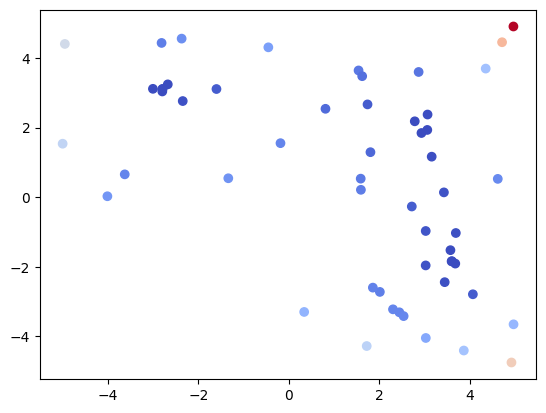

In [10]:

num_itr = 20

class ConstrainedQExpectedImprovement(qExpectedImprovement):
    def __init__(self, model, constraint, **kwargs):
        super().__init__(model=model, **kwargs)
        self.constraint = constraint

    def forward(self, x):
        return super().forward(x) * self.constraint(x).squeeze()

X = (10 * torch.rand(size=(50, 2)).double() - 5)
#X= X.unsqueeze(1)
good_X = X[np.isnan(himmelblau(*X.squeeze().T))==False]
Y = himmelblau(*good_X.T).double()*(-1)
Y = Y.unsqueeze(dim = -1)
Quality = (-1) * np.isnan(himmelblau(*X.T)).double() + 1
Quality = Quality.unsqueeze(dim = -1)
model = SingleTaskGP(good_X, Y, input_transform=Normalize(d=2), outcome_transform=Standardize(m=1))
quality_model = SingleTaskGP(X, Quality, input_transform=Normalize(d=2), outcome_transform=Standardize(m=1))
botorch.fit.fit_gpytorch_mll(gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model))
botorch.fit.fit_gpytorch_mll(gpytorch.mlls.ExactMarginalLogLikelihood(quality_model.likelihood, quality_model))
for i in tqdm(range(num_itr)):
    #set best_y to the best value of the function we have achieved
    best_y = torch.max(Y)  #shouldn't best_y should be torch_min, since we are negating the function?
    #define bounds
    bounds = torch.stack([torch.zeros(2), torch.ones(2)])*10 - 5
    #set constraint function to be mean of posterior of Quality model, which should give us prob. that a point is good
    def constraint(x):
        return quality_model.posterior(x).mean.detach()
    #acq_fun = qExpectedImprovement(model, best_y)
    acq_fun = ConstrainedQExpectedImprovement(model = model, constraint = constraint, best_f = best_y) 
    #optimize aquisition function

    candidate, acq_value = optimize_acqf(acq_fun, bounds = bounds, q=1, num_restarts=5, raw_samples = 10)

    #add selected point to training data for quality model
    X = torch.cat((X, candidate), 0)
    Quality = torch.cat((Quality.squeeze(), (-1) * np.isnan(himmelblau(*candidate.T)).double() + 1), 0)
    Quality = Quality.unsqueeze(dim = -1)
    #if the point is sample-able, add point to data for main model
    if np.isnan(himmelblau(*candidate.T))==False:
        good_X = torch.cat((good_X, candidate), 0)
        y_val = himmelblau(*candidate.T).double()*(-1)
        Y = torch.cat((Y.squeeze(), y_val), 0)
        Y = Y.unsqueeze(dim = -1)
    #refit the model
    model = SingleTaskGP(good_X, Y, input_transform=Normalize(d=2), outcome_transform=Standardize(m=1))
    quality_model = SingleTaskGP(X, Quality, input_transform=Normalize(d=2), outcome_transform=Standardize(m=1))
    botorch.fit.fit_gpytorch_mll(gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model))
    botorch.fit.fit_gpytorch_mll(gpytorch.mlls.ExactMarginalLogLikelihood(quality_model.likelihood, quality_model))

plt.scatter(*good_X.T, c=(-1)*Y)

In [4]:
class DirichletGPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_classes):
        super(DirichletGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean(batch_shape=torch.Size((num_classes,)))
        self.covar_module = ScaleKernel(
            RBFKernel(batch_shape=torch.Size((num_classes,))),
            batch_shape=torch.Size((num_classes,)),
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

class LatentGP(SingleTaskGP):
    def __init__(self, train_inputs, train_targets, skew_dims=True, *args, **kwargs):
        super().__init__(train_inputs, train_targets, *args, **kwargs)

        self.mean_module = gpytorch.means.ConstantMean(constant_prior=gpytorch.priors.NormalPrior(loc=0, scale=1))

        self.covar_module = kernels.LatentKernel(
            num_inputs=train_inputs.shape[-1],
            num_outputs=train_targets.shape[-1],
            skew_dims=skew_dims,
            priors=True,
            scale=True,
            **kwargs,
        )

        self.trained = False


In [16]:
#Quality = Quality.long().squeeze()
#quality_likelihood = DirichletClassificationLikelihood(Quality, learn_additional_noise=True)
#quality_model = DirichletGPModel(X, quality_likelihood.transformed_targets, quality_likelihood, num_classes=quality_likelihood.num_classes)

def refit_quality_model(quality_likelihood, quality_model, x):
    training_iter = 50
    
    # Find optimal model hyperparameters
    quality_model.train()
    quality_likelihood.train()
    
    # Use the adam optimizer
    optimizer = torch.optim.Adam(quality_model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters
    
    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(quality_likelihood, quality_model)
    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = quality_model(x)
        # Calc loss and backprop gradients
        loss = -mll(output, quality_likelihood.transformed_targets).sum()
        loss.backward()
        # if i % 5 == 0:
        #     print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        #         i + 1, training_iter, loss.item(),
        #         quality_model.covar_module.base_kernel.lengthscale.mean().item(),
        #         quality_model.likelihood.second_noise_covar.noise.mean().item()
        #     ))
        optimizer.step()
    # quality_likelihood.eval()
    # quality_model.eval()


IndexError: index 2 is out of bounds for dimension 0 with size 2

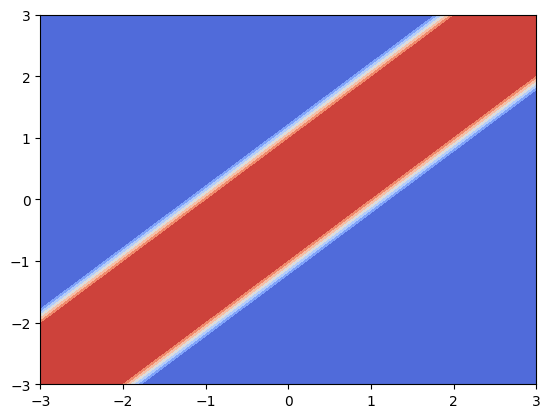

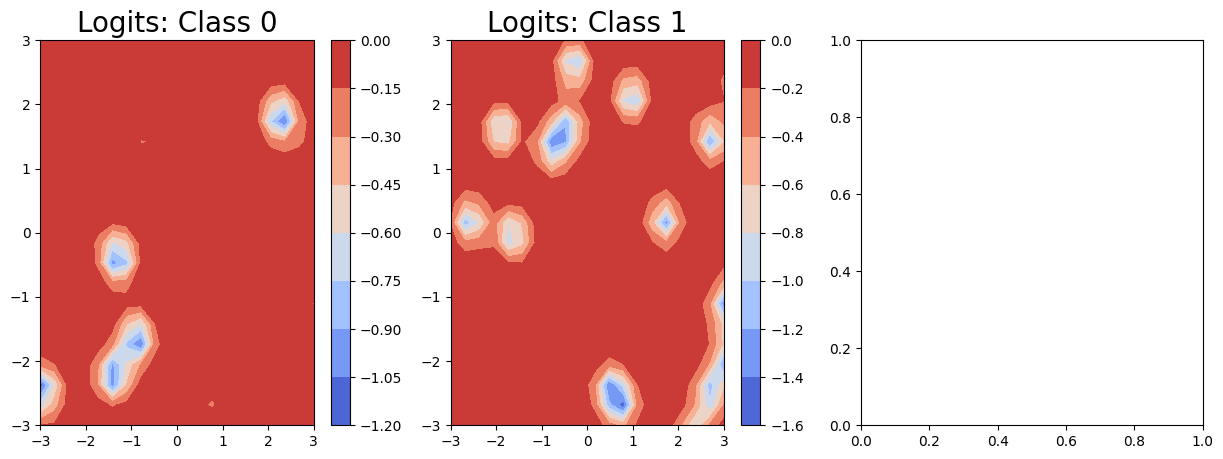

In [108]:
# def gen_data(num_data):
#     x = X[:, 0].unsqueeze(1)
#     y = X[:, 1].unsqueeze(1)
#     u = torch.rand(1)
#     data_fn = lambda x, y: ((-1) * np.isnan(himmelblau(x, y)) + 1).float()
#     latent_fn = data_fn(x, y)
#     z = torch.round(latent_fn).long().squeeze()
#     return torch.cat((x,y),dim=1), z, data_fn
# train_x, Quality, genfn = gen_data(50)

genfn = lambda x, y: ((-1) * np.isnan(himmelblau(x, y)) + 1)

# def gen_data(num_data, seed = 2019):
#     torch.random.manual_seed(seed)

#     x = torch.randn(num_data,1)
#     y = torch.randn(num_data,1)

#     u = torch.rand(1)
#     data_fn = lambda x, y: 1 * torch.sin(0.15 * u * 3.1415 * (x + y)) + 1
#     latent_fn = data_fn(x, y)
#     z = torch.round(latent_fn).long().squeeze()
#     return torch.cat((x,y),dim=1), z, data_fn
# train_x, train_y, genfn = gen_data(500)

# quality_likelihood = DirichletClassificationLikelihood(Quality, learn_additional_noise=True)
# quality_model = DirichletGPModel(train_x, quality_likelihood.transformed_targets, quality_likelihood, num_classes=quality_likelihood.num_classes)
# refit_quality_model(quality_likelihood, quality_model, train_x)
#plt.scatter(train_x[:,0].numpy(), train_x[:,1].numpy(), c = Quality)

quality_likelihood.eval()
quality_model.eval()

test_d1 = np.linspace(-3, 3, 20)
test_d2 = np.linspace(-3, 3, 20)

test_x_mat, test_y_mat = np.meshgrid(test_d1, test_d2)
test_x_mat, test_y_mat = torch.Tensor(test_x_mat), torch.Tensor(test_y_mat)

test_x = torch.cat((test_x_mat.view(-1,1), test_y_mat.view(-1,1)),dim=1)
test_labels = torch.round(genfn(test_x_mat, test_y_mat))
test_y = test_labels.view(-1).long()

plt.contourf(test_x_mat.numpy(), test_y_mat.numpy(), test_labels.numpy())

with gpytorch.settings.fast_pred_var(), torch.no_grad():
    test_dist = quality_model(test_x)
    pred_means = test_dist.loc
    
fig, ax = plt.subplots(1, 3, figsize = (15, 5))

for i in range(3):
    im = ax[i].contourf(
        test_x_mat.numpy(), test_y_mat.numpy(), pred_means[i].numpy().reshape((20,20))
    )
    fig.colorbar(im, ax=ax[i])
    ax[i].set_title("Logits: Class " + str(i), fontsize = 20)
    
# pred_samples = test_dist.sample(torch.Size((256,))).exp()
# probabilities = (pred_samples / pred_samples.sum(-2, keepdim=True)).mean(0)

# levels = np.linspace(0, 1.05, 20)
# for i in range(2):
#     im = ax[i].contourf(
#         test_x_mat.numpy(), test_y_mat.numpy(), probabilities[i].numpy().reshape((20,20)), levels=levels
#     )
#     fig.colorbar(im, ax=ax[i])
#     ax[i].set_title("Probabilities: Class " + str(i), fontsize = 20)

In [55]:
quality_likelihood.num_classes

2

In [1]:
def himmelblau(x1, x2):
    """
    Himmelblau's function (https://en.wikipedia.org/wiki/Himmelblau%27s_function)
    """
    f = (x1**2 + x2 - 11) ** 2 + (x1 + x2**2 - 7) ** 2

    # return torch.Tensor(np.where((x1 > 0) | (x2 > 0), f, np.nan))
    return torch.Tensor(np.where(np.abs(x1 - x2) < 1, f, np.nan))


class ConstrainedQExpectedImprovement(qExpectedImprovement):
    def __init__(self, model, constraint, **kwargs):
        super().__init__(model=model, **kwargs)
        self.constraint = constraint

    def forward(self, x):
        return super().forward(x) * self.constraint(x).squeeze()

X = (10 * torch.rand(size=(50, 2)) - 5).double()
#X= X.unsqueeze(1)
good_X = X[np.isnan(himmelblau(*X.squeeze().T))==False].double()
Y = himmelblau(*good_X.T).double()*(-1)
Y = Y.unsqueeze(dim = -1)
Quality = ((-1) * np.isnan(himmelblau(*X.T)) + 1).long()
#Quality = Quality.unsqueeze(dim = -1)
model = SingleTaskGP(good_X, Y, input_transform=Normalize(d=2), outcome_transform=Standardize(m=1))

quality_likelihood = DirichletClassificationLikelihood(Quality, learn_additional_noise=True).double()
quality_model = LatentDirichletClassifier(train_inputs = X, train_targets = quality_likelihood.transformed_targets.transpose(-1, -2).double(), likelihood = quality_likelihood, skew_dims =[(0,), (1,)])

botorch.fit.fit_gpytorch_mll(gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model))
botorch.fit.fit_gpytorch_mll(gpytorch.mlls.ExactMarginalLogLikelihood(quality_model.likelihood, quality_model))


for i in tqdm(range(num_itr)):
    #set best_y to the best value of the function we have achieved
    best_y = torch.max(Y) 
    #define bounds
    bounds = torch.stack([torch.zeros(2), torch.ones(2)])*10 - 5
    #set constraint function to be mean of posterior of Quality model, which should give us prob. that a point is good
    def constraint(x):
        return quality_model.probabilities(x)[..., -1].squeeze()
        
    acq_fun = ConstrainedQExpectedImprovement(model = model, constraint = constraint, best_f = best_y) 
    #optimize aquisition function
    candidate, acq_value = optimize_acqf(acq_fun, bounds = bounds, q=1, num_restarts=5, raw_samples = 10)
    #add selected point to training data for quality model
    X = torch.cat((X, candidate.double()), 0)
    Quality = torch.cat((Quality.squeeze(), (-1) * np.isnan(himmelblau(*candidate.T)).long() + 1), 0)
    #Quality = Quality.unsqueeze(dim = -1)
    #if the point is sample-able, add point to data for main model
    if np.isnan(himmelblau(*candidate.T))==False:
        good_X = torch.cat((good_X, candidate), 0)
        y_val = himmelblau(*candidate.T).double()*(-1)
        Y = torch.cat((Y.squeeze(), y_val), 0)
        Y = Y.unsqueeze(dim = -1)
    #refit the model
    model = SingleTaskGP(good_X, Y, input_transform=Normalize(d=2), outcome_transform=Standardize(m=1))
    quality_likelihood = DirichletClassificationLikelihood(Quality, learn_additional_noise=True)
    quality_model = LatentDirichletClassifier(X, quality_likelihood.transformed_targets.transpose(-1, -2).double(), likelihood = quality_likelihood, skew_dims = [(0, ), (1,)])
    botorch.fit.fit_gpytorch_mll(gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model))
    botorch.fit.fit_gpytorch_mll(gpytorch.mlls.ExactMarginalLogLikelihood(quality_model.likelihood, quality_model))

plt.scatter(*good_X.T, c=(-1)*Y)

NameError: name 'qExpectedImprovement' is not defined

In [110]:
def constraint(x):
        pred_samples = quality_model(x).sample(torch.Size((256,))).exp()
        probabilities = (pred_samples / pred_samples.sum(-2, keepdim=True)).mean(0)
        return probabilities[1].unsqueeze(-1).double()

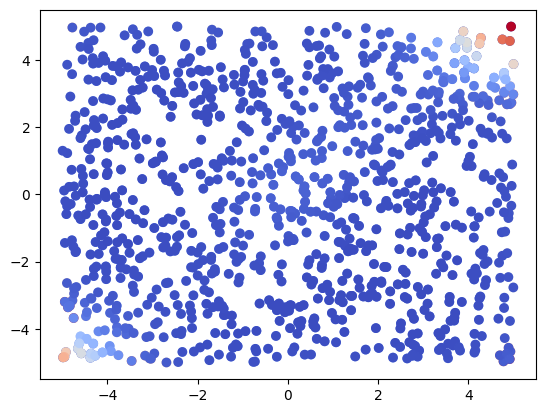

In [116]:
test_X = 10 * torch.rand(size=(1024, 1, 2)).double() - 5
plt.scatter(*test_X.squeeze().T, c=acq_fun(test_X).detach())
plt.scatter(*test_X.squeeze().T, c=quality_model.probabilities(test_X).detach()[..., 1].squeeze())

In [106]:
quality_model.train_inputs[0].shape

torch.Size([2, 70, 2])

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:10<00:00,  1.41s/it]


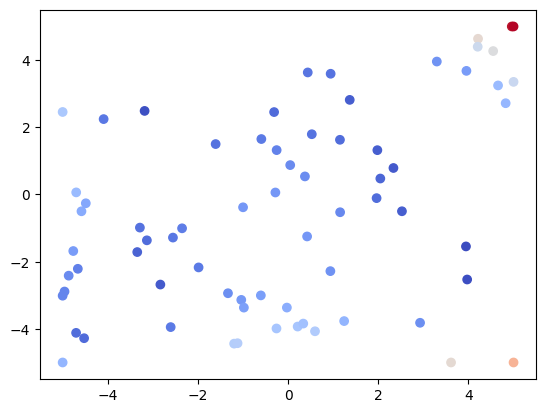

In [44]:
num_itr = 50

def himmelblau(x1, x2):
    """
    Himmelblau's function (https://en.wikipedia.org/wiki/Himmelblau%27s_function)
    """
    f = (x1**2 + x2 - 11) ** 2 + (x1 + x2**2 - 7) ** 2

    return f

class ConstrainedQExpectedImprovement(qExpectedImprovement):
    def __init__(self, model, constraint, **kwargs):
        super().__init__(model=model, **kwargs)
        self.constraint = constraint

    def forward(self, x):
        return (75-super().forward(x))**2 * self.constraint(x).squeeze()

X = (10 * torch.rand(size=(20, 2)).double() - 5)
#X= X.unsqueeze(1)
good_X = X[np.isnan(himmelblau(*X.squeeze().T))==False]
Y = himmelblau(*good_X.T).double()*(-1)
Y = Y.unsqueeze(dim = -1)
Quality = (-1) * np.isnan(himmelblau(*X.T)).double() + 1
Quality = Quality.unsqueeze(dim = -1)
model = SingleTaskGP(good_X, Y, input_transform=Normalize(d=2), outcome_transform=Standardize(m=1))
quality_model = SingleTaskGP(X, Quality, input_transform=Normalize(d=2), outcome_transform=Standardize(m=1))
botorch.fit.fit_gpytorch_mll(gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model))
botorch.fit.fit_gpytorch_mll(gpytorch.mlls.ExactMarginalLogLikelihood(quality_model.likelihood, quality_model))
for i in tqdm(range(num_itr)):
    #set best_y to the best value of the function we have achieved
    best_y = torch.max(Y)  #shouldn't best_y should be torch_min, since we are negating the function?
    #define bounds
    bounds = torch.stack([torch.zeros(2), torch.ones(2)])*10 - 5
    #set constraint function to be mean of posterior of Quality model, which should give us prob. that a point is good
    def constraint(x):
        return quality_model.posterior(x).mean.detach()
    #acq_fun = qExpectedImprovement(model, best_y)
    acq_fun = ConstrainedQExpectedImprovement(model = model, constraint = constraint, best_f = best_y) 
    #optimize aquisition function

    candidate, acq_value = optimize_acqf(acq_fun, bounds = bounds, q=1, num_restarts=5, raw_samples = 10)

    #add selected point to training data for quality model
    X = torch.cat((X, candidate), 0)
    Quality = torch.cat((Quality.squeeze(), (-1) * np.isnan(himmelblau(*candidate.T)).double() + 1), 0)
    Quality = Quality.unsqueeze(dim = -1)
    #if the point is sample-able, add point to data for main model
    if np.isnan(himmelblau(*candidate.T))==False:
        good_X = torch.cat((good_X, candidate), 0)
        y_val = himmelblau(*candidate.T).double()*(-1)
        Y = torch.cat((Y.squeeze(), y_val), 0)
        Y = Y.unsqueeze(dim = -1)
    #refit the model
    model = SingleTaskGP(good_X, Y, input_transform=Normalize(d=2), outcome_transform=Standardize(m=1))
    quality_model = SingleTaskGP(X, Quality, input_transform=Normalize(d=2), outcome_transform=Standardize(m=1))
    botorch.fit.fit_gpytorch_mll(gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model))
    botorch.fit.fit_gpytorch_mll(gpytorch.mlls.ExactMarginalLogLikelihood(quality_model.likelihood, quality_model))

plt.scatter(*good_X.T, c=(-1)*Y)

 20%|████████████████▌                                                                  | 4/20 [00:04<00:18,  1.16s/it]C:\Users\megha\Anaconda3\envs\nsls2\Lib\site-packages\botorch\optim\optimize.py:588: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of initial conditions.
  return _optimize_acqf_batch(opt_inputs=opt_inputs)
 50%|█████████████████████████████████████████                                         | 10/20 [00:11<00:10,  1.09s/it]C:\Users\megha\Anaconda3\envs\nsls2\Lib\site-packages\botorch\optim\optimize.py:588: RuntimeWarning: Optimization failed in `gen_candidates_scipy` with the following warning(s):
[OptimizationWarning('Optimization failed within `scipy.optimize.minimize` with status 2 and message ABNORMAL_TERMINATION_IN_LNSRCH.')]
Trying again with a new set of

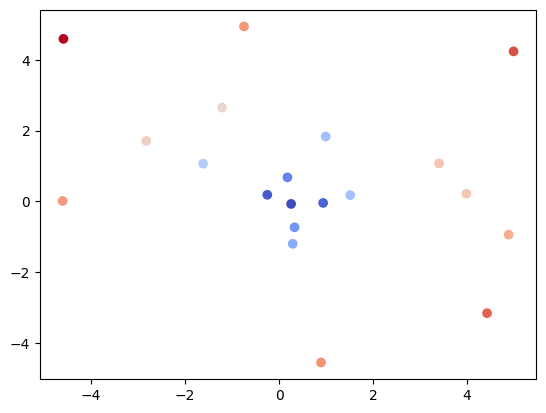

In [54]:
num_itr = 20

from numpy import cos
from numpy import e
from numpy import pi
from numpy import exp
from numpy import sqrt

def ackley(x1, x2):
    """
    Ackley's Function
    """
    f = -20.0 * exp(-0.2 * sqrt(0.5 * (x1**2 + x2**2)))-exp(0.5 * (cos(2 * 
  pi * x1)+cos(2 * pi * x2))) + e + 20

    return torch.Tensor(np.where((x1 > 0) | (x2 > 0), f, np.nan))

class ConstrainedQExpectedImprovement(qExpectedImprovement):
    def __init__(self, model, constraint, **kwargs):
        super().__init__(model=model, **kwargs)
        self.constraint = constraint

    def forward(self, x):
        return super().forward(x) * self.constraint(x).squeeze()

X = (10 * torch.rand(size=(20, 2)).double() - 5)
#X= X.unsqueeze(1)
good_X = X[np.isnan(ackley(*X.squeeze().T))==False]
Y = ackley(*good_X.T).double()*(-1)
Y = Y.unsqueeze(dim = -1)
Quality = (-1) * np.isnan(ackley(*X.T)).double() + 1
Quality = Quality.unsqueeze(dim = -1)
model = SingleTaskGP(good_X, Y, input_transform=Normalize(d=2), outcome_transform=Standardize(m=1))
quality_model = SingleTaskGP(X, Quality, input_transform=Normalize(d=2), outcome_transform=Standardize(m=1))
botorch.fit.fit_gpytorch_mll(gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model))
#botorch.fit.fit_gpytorch_mll(gpytorch.mlls.ExactMarginalLogLikelihood(quality_model.likelihood, quality_model))
for i in tqdm(range(num_itr)):
    #set best_y to the best value of the function we have achieved
    best_y = torch.max(Y)  #shouldn't best_y should be torch_min, since we are negating the function?
    #define bounds
    bounds = torch.stack([torch.zeros(2), torch.ones(2)])*10 - 5
    #set constraint function to be mean of posterior of Quality model, which should give us prob. that a point is good
    def constraint(x):
        return quality_model.posterior(x).mean.detach()
    #acq_fun = qExpectedImprovement(model, best_y)
    acq_fun = ConstrainedQExpectedImprovement(model = model, constraint = constraint, best_f = best_y) 
    #optimize aquisition function

    candidate, acq_value = optimize_acqf(acq_fun, bounds = bounds, q=1, num_restarts=5, raw_samples = 10)

    #add selected point to training data for quality model
    X = torch.cat((X, candidate), 0)
    Quality = torch.cat((Quality.squeeze(), (-1) * np.isnan(ackley(*candidate.T)).double() + 1), 0)
    Quality = Quality.unsqueeze(dim = -1)
    #if the point is sample-able, add point to data for main model
    if np.isnan(ackley(*candidate.T))==False:
        good_X = torch.cat((good_X, candidate), 0)
        y_val = ackley(*candidate.T).double()*(-1)
        Y = torch.cat((Y.squeeze(), y_val), 0)
        Y = Y.unsqueeze(dim = -1)
    #refit the model
    model = SingleTaskGP(good_X, Y, input_transform=Normalize(d=2), outcome_transform=Standardize(m=1))
    quality_model = SingleTaskGP(X, Quality, input_transform=Normalize(d=2), outcome_transform=Standardize(m=1))
    botorch.fit.fit_gpytorch_mll(gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model))
    botorch.fit.fit_gpytorch_mll(gpytorch.mlls.ExactMarginalLogLikelihood(quality_model.likelihood, quality_model))

plt.scatter(*good_X.T, c=(-1)*Y)

In [55]:
quality_model.train_inputs

(tensor([[0.8996, 0.5241],
         [0.2178, 0.6745],
         [0.4259, 1.0000],
         [0.8412, 0.6106],
         [0.2356, 0.2594],
         [0.5999, 0.6872],
         [0.1098, 0.4530],
         [0.2476, 0.2580],
         [0.5899, 0.0443],
         [0.3789, 0.7694],
         [0.9436, 0.1846],
         [0.0412, 0.9648],
         [0.4921, 0.1958],
         [0.0827, 0.2314],
         [0.3388, 0.6098],
         [0.1874, 0.4044],
         [0.9895, 0.4080],
         [0.0395, 0.5037],
         [0.3729, 0.3715],
         [1.0000, 0.9292],
         [0.5183, 0.5708],
         [0.5262, 0.4953],
         [0.5335, 0.4288],
         [0.4094, 0.4136],
         [0.4101, 0.4131],
         [0.1952, 0.0362],
         [0.4138, 0.4165],
         [0.5944, 0.4981],
         [0.0000, 0.0000],
         [0.4330, 0.4460],
         [0.4627, 0.4769],
         [0.4754, 0.4851],
         [0.4155, 0.4647],
         [0.6520, 0.5202],
         [0.3380, 0.4137],
         [0.5296, 0.3819],
         [0.0931, 0.0000],
 